<a href="https://colab.research.google.com/github/Yashyupr/Analytics-Using-Python/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
col_pal = sns.color_palette()

import xgboost as xgb # for forecasting
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

#Upload the Kaggle API credentials JSON file
files.upload()

import json

# Load the uploaded JSON file
with open('kaggle.json', 'r') as file:
    kaggle_credentials = json.load(file)

# Extract username and key
username = kaggle_credentials['username']
key = kaggle_credentials['key']

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json #6 is permission to admin 0 is no permission for user and external user

In [ ]:
!kaggle datasets download -d hajarshokrgozarr/10-pjme-hourly

  0% 0.00/770k [00:00<?, ?B/s]
100% 770k/770k [00:00<00:00, 71.5MB/s]


In [ ]:
!unzip 10-pjme-hourly.zip -d 10-pjme-hourly

Archive:  10-pjme-hourly.zip
  inflating: 10-pjme-hourly/10.PJME_hourly.csv  


In [ ]:
df = pd.read_csv('/content/10-pjme-hourly/10.PJME_hourly.csv')
df = df.set_index('Datetime')

In [ ]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'PJME Energy Used in MW'}, xlabel='Datetime'>

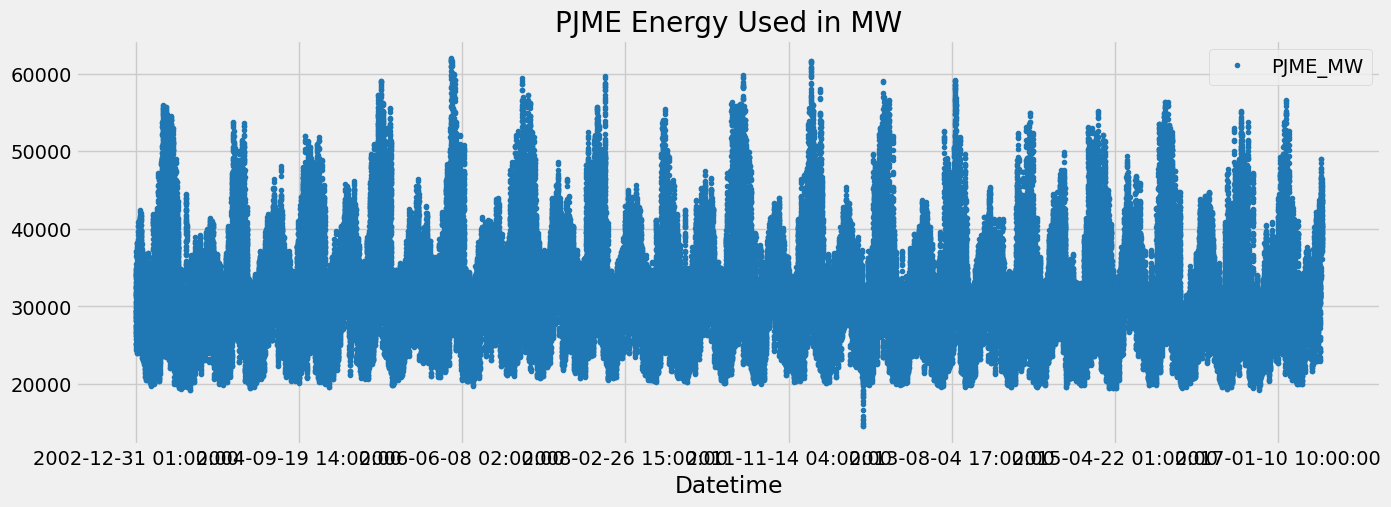

In [ ]:
df.plot(style = '.',
        figsize = (15,5),
        color = col_pal[0],
        title ="PJME Energy Used in MW")

In [ ]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [ ]:
#Converting Data Type to Date Time
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Used in MW'}, xlabel='Datetime'>

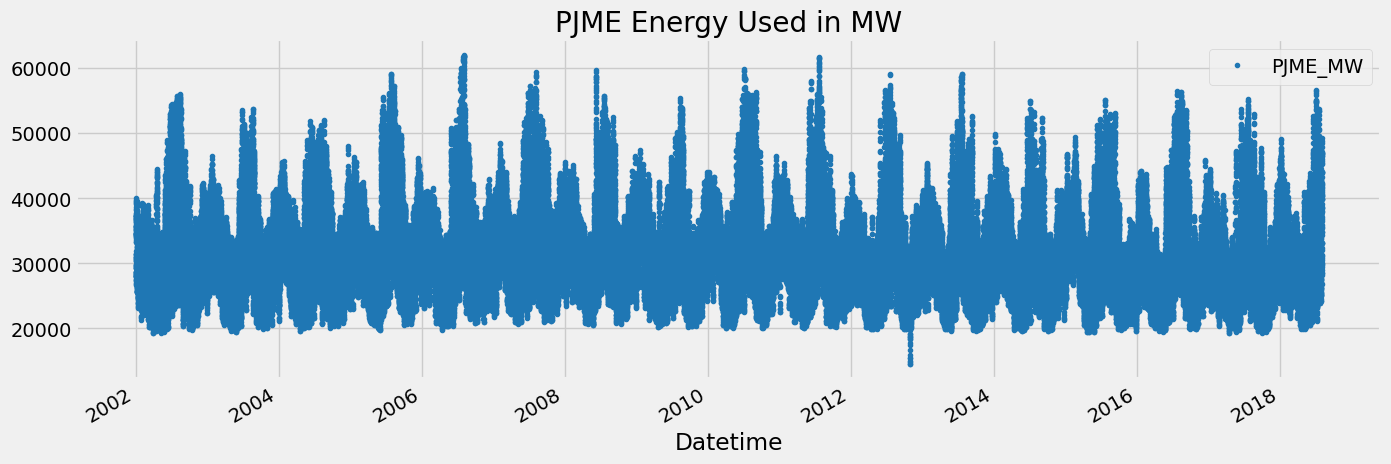

In [ ]:
df.plot(style = '.',
        figsize = (15,5),
        color = col_pal[0],
        title ="PJME Energy Used in MW")

# **Train / Test Split**

In [ ]:
train = df.loc[df.index < '01-01-2015'] #Locating data below 01-01-2015 as train
test = df.loc[df.index >= '01-01-2015'] #Locating data below 01-01-2015 as test

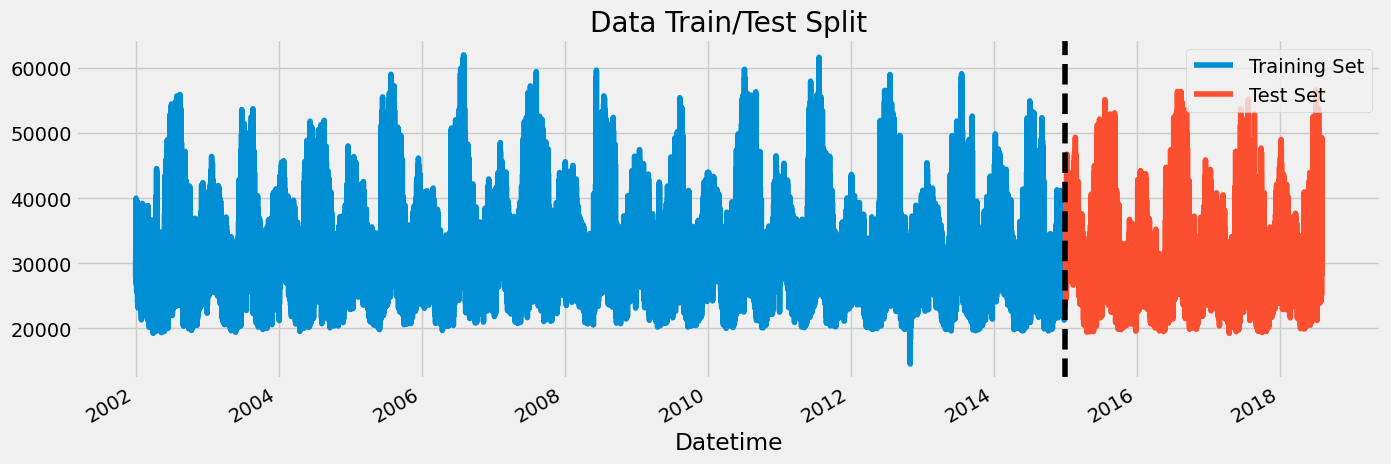

In [ ]:
fig, ax = plt.subplots (figsize = (15,5))

train.plot(ax = ax, label = "Training Set", title = "Data Train/Test Split")
test.plot(ax = ax, label = "Test Set")
ax.axvline('01-01-2015', color = 'black', ls = '--') #Adding vertical line and line style
ax.legend (['Training Set', 'Test Set'])
plt.show()

In [ ]:
# Locating Weekly Data
df.loc[(pd.to_datetime(df.index) > '2010-01-01') & (pd.to_datetime(df.index) < '2010-01-08')]

,PJME_MW
Datetime,
2010-01-07 01:00:00,32194.0
2010-01-07 02:00:00,31254.0
2010-01-07 03:00:00,30894.0
2010-01-07 04:00:00,30937.0
2010-01-07 05:00:00,31660.0
...,...
2010-01-01 20:00:00,35385.0
2010-01-01 21:00:00,35105.0
2010-01-01 22:00:00,34309.0


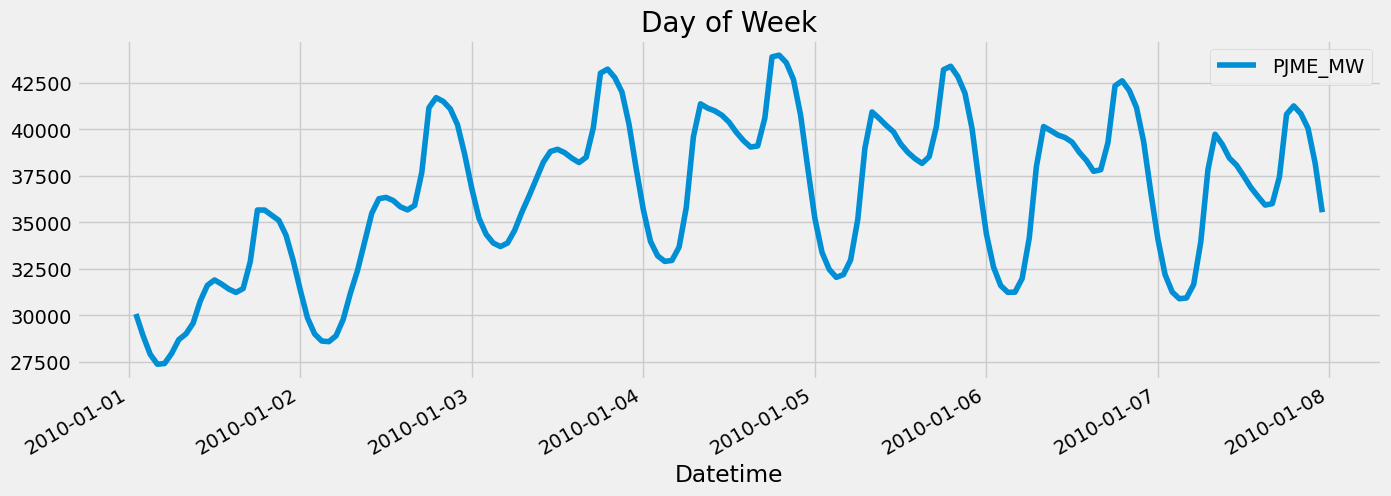

In [ ]:
week = df.loc[(pd.to_datetime(df.index) > '2010-01-01') & (pd.to_datetime(df.index) < '2010-01-08')]
week.plot(figsize = (15,5), title = "Day of Week")
plt.show()

# **Feature Creation**

In [ ]:
def create_features(df): #Create time series features based on time series index
  df = df.copy()
  df['Hour'] = df.index.hour
  df['DayOfWeek'] = df.index.dayofweek
  df['Month'] = df.index.month
  df['Quarter'] = df.index.quarter
  df['Year'] = df.index.year
  df['DayOfYear'] = df.index.dayofyear
  return df

df = create_features(df)

In [ ]:
df.head()

,PJME_MW,Hour,DayOfWeek,Month,Quarter,Year,DayOfYear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365


# **Visualize Feature to Target Relationship**

Text(0.5, 1.0, 'MW by Hour')

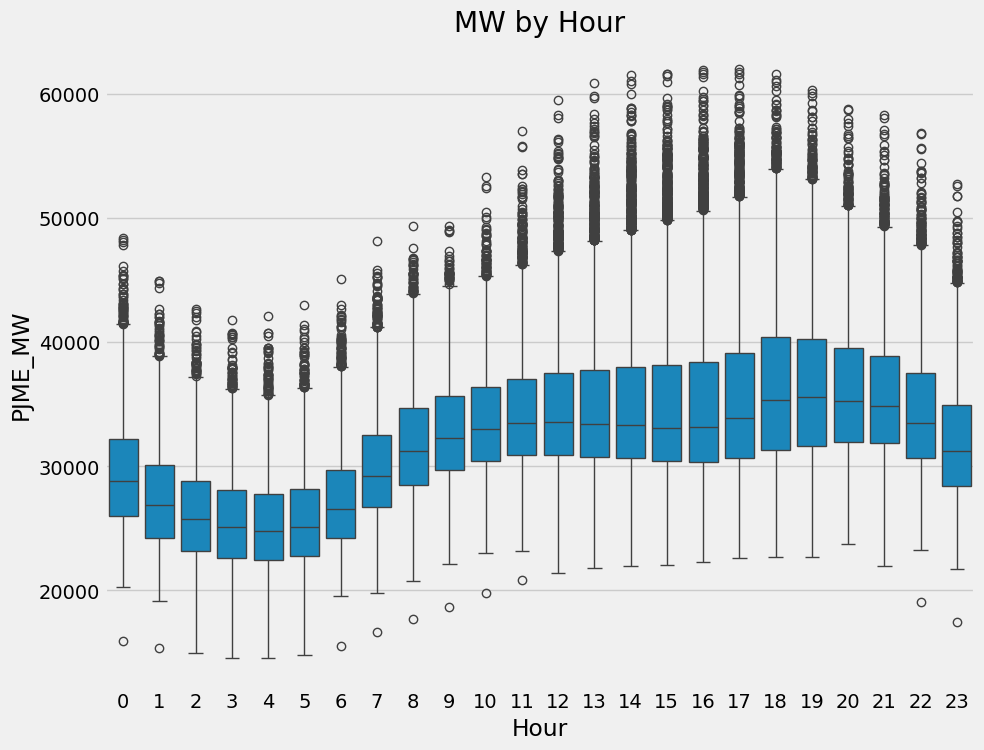

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'Hour', y = 'PJME_MW')
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Month')

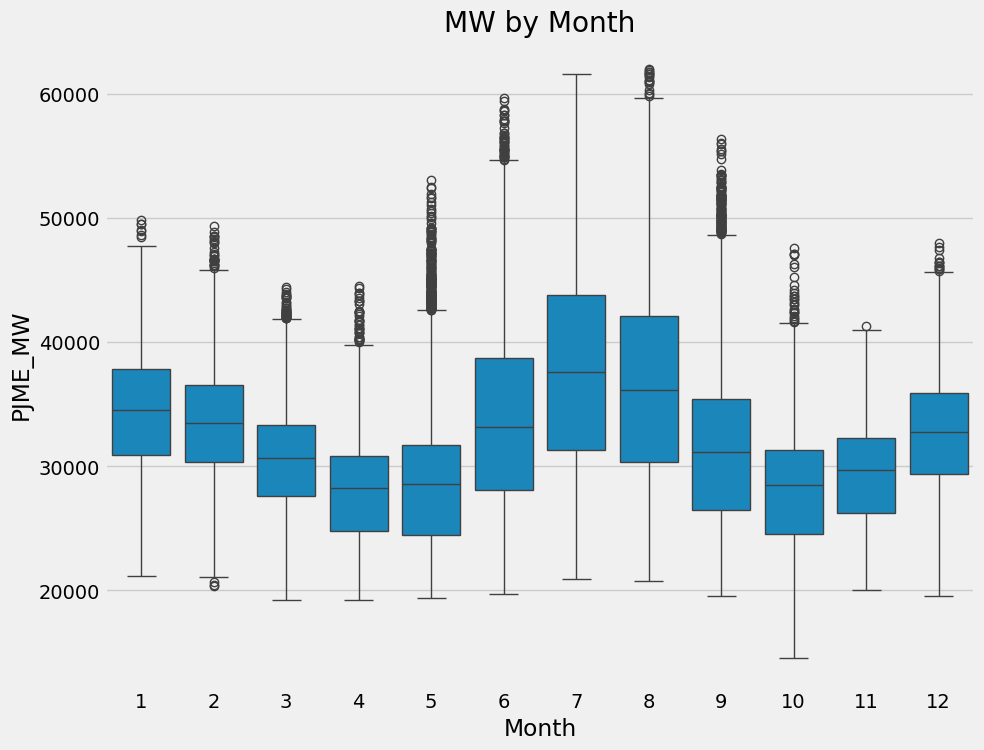

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'Month', y = 'PJME_MW')
ax.set_title('MW by Month')

# **Create the Regression Model**

In [ ]:
# Apply create_features function to the training and testing DataFrames separately
train = create_features(train)
test = create_features(test)

In [ ]:
df.columns

Index(['PJME_MW', 'Hour', 'DayOfWeek', 'Month', 'Quarter', 'Year',
       'DayOfYear'],
      dtype='object')

In [ ]:
FEATURES = ['Hour', 'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear']
TARGET = 'PJME_MW'

In [ ]:
train.columns

Index(['PJME_MW', 'Hour', 'DayOfWeek', 'Month', 'Quarter', 'Year',
       'DayOfYear'],
      dtype='object')

In [ ]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
#Number of estimators for how many trees the boosted tree algorithm will create

# Fit in training set
reg.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_test, Y_test)],
        verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# **Feature Importance**

In [ ]:
reg.feature_importances_

array([0.46387812, 0.1620048 , 0.02888114, 0.20316096, 0.02382433,
       0.11825063], dtype=float32)

In [ ]:
#Building pandas data frame where the data is feature importances
fi = pd.DataFrame(reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

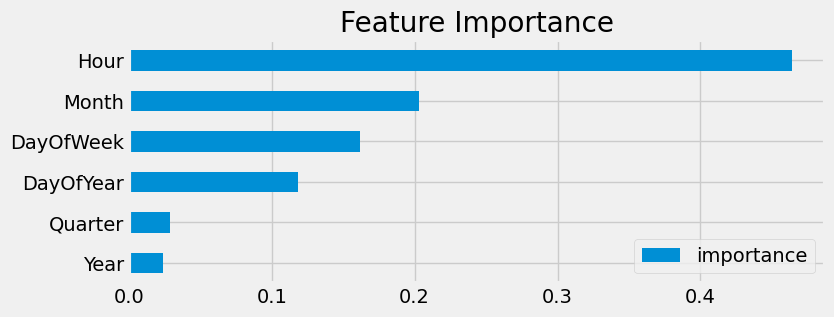

In [ ]:
fi.sort_values('importance').plot(kind = 'barh', figsize = (8,3), title = 'Feature Importance')

# **Forecast on Test**

In [ ]:
reg.predict(X_test)

array([32393.352, 29040.168, 27877.018, ..., 36229.527, 35141.754,
       32339.713], dtype=float32)

In [ ]:
test['Prediction'] = reg.predict(X_test)

In [ ]:
df.merge(test[['Prediction']], how = 'left', left_index = True, right_index = True)

,PJME_MW,Hour,DayOfWeek,Month,Quarter,Year,DayOfYear,Prediction_x,Prediction_y,Prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,8,3,2018,214,41545.953125,41545.953125,41545.953125
2018-08-02 21:00:00,43256.0,21,3,8,3,2018,214,41135.625000,41135.625000,41135.625000
2018-08-02 22:00:00,41552.0,22,3,8,3,2018,214,39968.492188,39968.492188,39968.492188


In [ ]:
df = df.merge(test[['Prediction']], how = 'left', left_index = True, right_index = True)

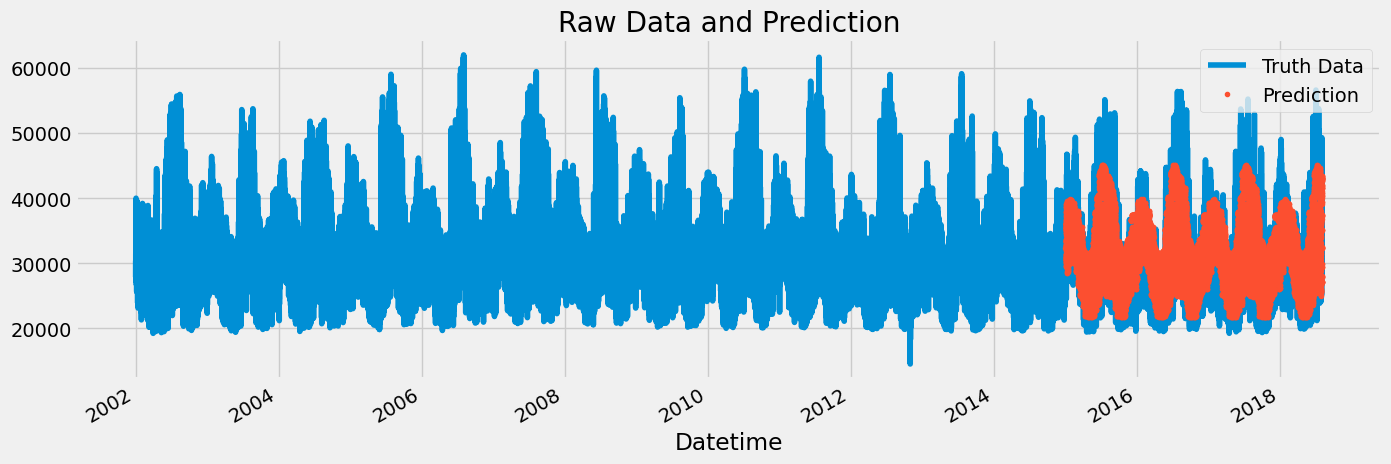

In [ ]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['Prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title ('Raw Data and Prediction')
plt.show()

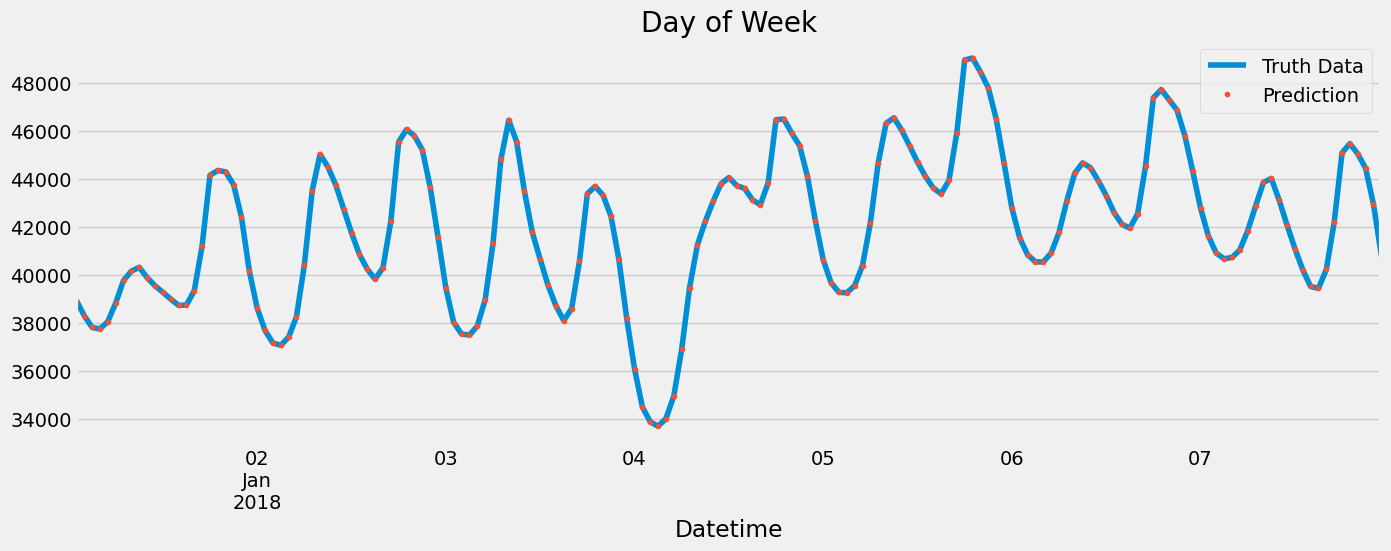

In [ ]:
#One week prediction
week = df.loc[(pd.to_datetime(df.index) > '2018-01-01') & (pd.to_datetime(df.index) < '2018-01-08')]['PJME_MW']
week.plot(figsize = (15,5), title = "Day of Week")
df.loc[(pd.to_datetime(df.index) > '2018-01-01') & (pd.to_datetime(df.index) < '2018-01-08')]['PJME_MW']\
.plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

# **Calculate Error**

In [ ]:
mean_squared_error(test['PJME_MW'] , test['Prediction'])

13995306.798972495

In [ ]:
np.sqrt(mean_squared_error(test['PJME_MW'] , test['Prediction']))

3741.030178837441

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'] , test['Prediction']))
print(f'RMSE on Test Set: {score:0.2f}')

RMSE on Test Set: 3741.03


In [ ]:
test[TARGET] - test['Prediction']

Datetime
2015-01-01 00:00:00     408.648438
2015-12-31 01:00:00   -4735.167969
2015-12-31 02:00:00   -4721.017578
2015-12-31 03:00:00   -5062.720703
2015-12-31 04:00:00   -5246.720703
                          ...     
2018-01-01 20:00:00    5660.753906
2018-01-01 21:00:00    5255.515625
2018-01-01 22:00:00    6172.472656
2018-01-01 23:00:00    5022.246094
2018-01-02 00:00:00    6268.287109
Length: 31440, dtype: float64

In [ ]:
#Absolute value of error
np.abs(test[TARGET] - test['Prediction'])

Datetime
2015-01-01 00:00:00     408.648438
2015-12-31 01:00:00    4735.167969
2015-12-31 02:00:00    4721.017578
2015-12-31 03:00:00    5062.720703
2015-12-31 04:00:00    5246.720703
                          ...     
2018-01-01 20:00:00    5660.753906
2018-01-01 21:00:00    5255.515625
2018-01-01 22:00:00    6172.472656
2018-01-01 23:00:00    5022.246094
2018-01-02 00:00:00    6268.287109
Length: 31440, dtype: float64

In [ ]:
test['error'] = np.abs(test[TARGET] - test['Prediction'])

In [ ]:
#Worst and Best Predicted Days
test.index.date

array([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31),
       datetime.date(2015, 12, 31), ..., datetime.date(2018, 1, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 1, 2)], dtype=object)

In [ ]:
test['date'] = test.index.date

In [ ]:
test.groupby('date')['error'].mean()

date
2015-01-01    2965.745036
2015-01-02    2350.001383
2015-01-03    1680.229492
2015-01-04    4003.939941
2015-01-05    2540.236572
                 ...     
2018-07-30    3206.202962
2018-07-31    1963.001058
2018-08-01    2724.754313
2018-08-02    3267.145915
2018-08-03    3187.994141
Name: error, Length: 1311, dtype: float64

In [ ]:
#Top 5 best predicted days
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64

In [ ]:
#Top 5 worst predicted days
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64